In [3]:
using BioTools
using Plots, StatsPlots
using TreeTools
using StatsBase, Dates, Measures
using Dierckx, KernelDensity
using LaTeXStrings
include("../plot_functions.jl")
pyplot();

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


In [2]:
base= 20
lfs = base # Legend font size
alfs = base # axis label font size
tfs = base # title font size
atfs = base # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1280,960) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
annfs = 38

38

In [4]:
fp = Flu.FluPop("../alignments/aligned_h3n2_ha_aa.fasta", :aa, 
    Flu.flu_usual_header_fields, flulineage="h3n2", segment="ha");

Reading ../alignments/aligned_h3n2_ha_aa.fasta...
Read 44976 strains out of 61848. Filtered 16872. Could not read 0


In [5]:
binwidth = Day(30);
binspacing = Day(30);
startdate = Date(2000) 
Flu.bin_by_date!(fp, start = startdate, binwidth=binwidth, binspacing = binspacing);

In [6]:
ph_all = Flu.PosEvo(fp);

In [11]:
trajectories = Flu.all_trajectories(ph_all, keep_unfinished=true)
trajectories = Flu.previous_state_condition(trajectories, :lost)
trajectories = Flu.population_size_condition(trajectories, 10);
trajectories = Flu.frequency_condition(trajectories,0.30);
println("$(length(trajectories)) trajectories")

69 trajectories


## Rising trajectories at 30% frequency

In [8]:
αp = 0.4
αf = 0.25
cfixed = :red; clost = :blue; cother = :black
lw = 2

2

In [21]:
lostflag= false
fixedflag = false
otherflag = false
p = plot()
# Time = 0 line
plot!(p, [0, 0], [0, 1.], line=(3, :black), label="", alpha=0.5)
# Fixation and loss lines
plot!(p, [-24*30, 36*30], [0.95, 0.95], line=(:red, :dash), label="")
plot!(p, [-24*30, 36*30], [0.05, 0.05], line=(:blue, :dash), label="")
#Frequency bin
plot!(p, [-24*30, 0], [0.25, 0.25], line=(:black, 2, 0.7), label="")
plot!(p, [-24*30, 0], [0.35, 0.35], line=(:black, 2, 0.7), label="")
# Arrows
plot!(p, [-17*30, -17*30], [0.25,0.35], arrow=1.1, color=:black, label="")
plot!(p, [-17*30, -17*30], [0.35,0.25], arrow=1.1, color=:black, label="")
plot!(p, ann=(-21*30, 0.3, text(L"f_0", 30)))

for traj in trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]; iact = traj.index[:active]
        if traj.fixation==:lost
            lab = lostflag ? "" : ""
            lostflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=clost, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=clost, line=(lw, :dashdot))
        elseif traj.fixation==:fixed
            lab = fixedflag ? "" : ""
            fixedflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cfixed, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cfixed, line=(lw, :dashdot))
        else
            lab = otherflag ? "" : ""
            otherflag=true
            plot!(p, [x.value for x in traj.t[istart:iact]], traj.freq[istart:iact], 
                label=lab, alpha=αp, color=cother, linewidth=lw)
            plot!(p, [x.value for x in traj.t[iact:iend]], traj.freq[iact:iend], 
                label="", alpha=αf, color=cother, line=(lw, :dashdot))
        end
    end
end
plot!(p, size=(1280, 960), frame=:box)
plot!(p, guidefontsize=atfs, tickfontsize= atfs, legendfontsize = 22)
plot!(xlabel="Days", ylabel="")
plot!(p, xlim=(-24*30,30*36))
plot!(p, yticks = [0., 0.3, 1.])
plot!(p, ann = (-20.5*30, 0.95, text("B",annfs)))
p2_sb2 = p;

# Propagator

In [14]:
dat = Dict()
for traj in trajectories
    is = traj.index[:active]
    ie = is+48
    for i in is:ie
        if i > length(traj.t)
            t = (i-is)*binspacing.value
            traj.fixation != :poly && push!(get!(dat,t,Float64[]), traj.fixation==:fixed ? 1. : 0.)
        else
            push!(get!(dat,traj.t[i].value,Float64[]), traj.freq[i])
        end
    end
end

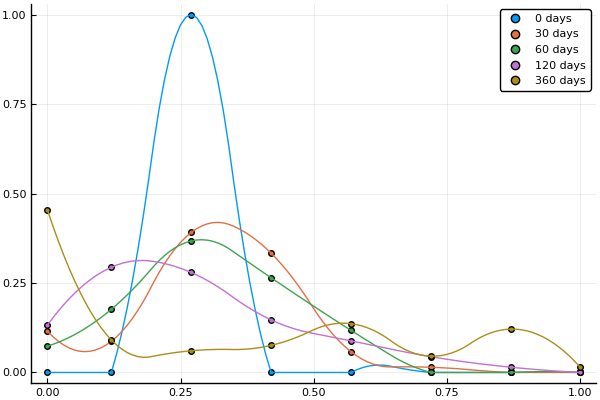

In [15]:
p = plot()
entropy_v_time = []
bins = vcat(0., collect(0.05:0.15:0.95), 1.001)
xs = vcat(0., collect(0.12:0.15:0.87), 1.)
for (i,t) in enumerate([0,30,60,120,360])
    h = fit(Histogram, dat[t], bins)
    ys = h.weights/sum(h.weights)
    scatter!(p, xs, ys, label="$t days", color=i)
    # Fitting a spline
    itp = Spline1D(xs, ys,k=2)
    x = 0.0:0.01:1.
    plot!(p, x, max.(itp(x),0.), label="", color=i)
    push!(entropy_v_time, [t StatsBase.entropy(h.weights/sum(h.weights))])
end
p

In [18]:
pa = []
entropy_v_time = []
bins = vcat(0., collect(0.05:0.15:0.95), 1.001)
xs = vcat(0., collect(0.05:0.15:0.8) .+ 0.1, 1.)

tvalues = [0,30,60,120,360,720]
for (i,t) in enumerate(tvalues)
    h = fit(Histogram, dat[t], bins)
    y = h.weights/sum(h.weights)
    # Fitting a spline
#     itp = CubicSplineInterpolation(xs, y[2:end-1])
    itp = Spline1D(xs,y,k=2)
    itplin = Spline1D(xs,y,k=1)
    f(x) = itplin(x)==0. ? 0. : (itplin(x) == 1. ? 1. : itp(x))
    x = min(xs...):0.01:max(xs...)
    # 
    push!(entropy_v_time, [t StatsBase.entropy(h.weights/sum(h.weights))])
    # Plot
    p = scatter(xs, y, label="$t days", color=i, markerstrokewidth=0.5, markersize=12) # data
    plot!(p, x, f.(x), label="", color=i, line=(3, 0.5))
    plot!(p, size=(1000,200), ylim=(-0.07,1.08), xlim=(-0.05,1.05), yticks=[0.,0.5,1.], legendfontsize=lfs)
    plot!(xticks=collect(0.1:0.2:0.9))
    plot!(p, tickfontsize=tfs, guidefontsize=alfs)
#     plot!(xticks=(vcat(0., collect(0.05:0.15:0.95), 1.0))
    if i == length(tvalues) || i == div(length(tvalues),2)
        plot!(p, xlabel="Frequency of mutation", guidefontsize=alfs, xtickfontsize=tfs)
    else
        plot!(p, xlabelfontsize=0, xtickfontsize=0)
    end
    if t == 0 
        plot!(p, ann=(0.02, 1.25, text("C",annfs)))
    end
    push!(pa, p)
end
entropy_v_time = vcat(entropy_v_time...);

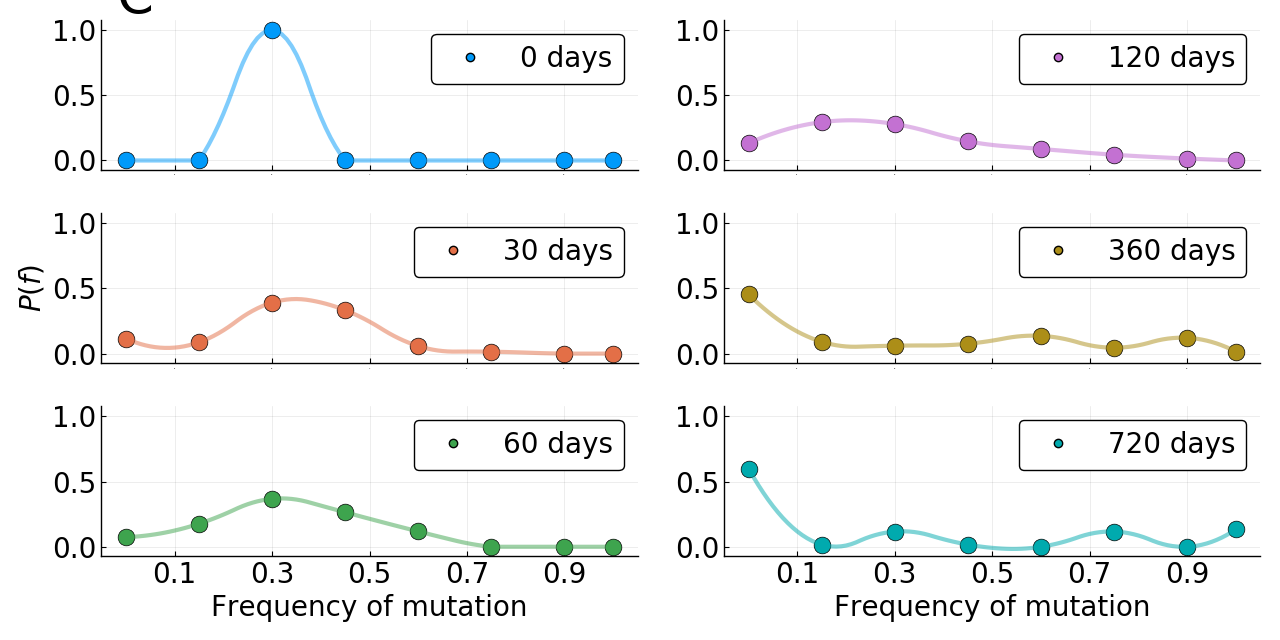

In [22]:
p_st_1 = plot(pa[1:3]..., ylabel=["" L"P(f)" ""], layout=(div(length(pa),2),1), size=(640,640), margin = 5mm, guidefontsize = atfs)
# plot!(p_st_1, xticks = [0.1, 0.3, 0.5, 0.7, 0.9])
p_st_2 = plot(pa[4:6]..., ylabel=["" "" ""], layout=(div(length(pa),2),1), size=(640,480), margin=5mm)
p2_sb3 = plot(p_st_1, p_st_2, layout=grid(1,2), size=(1280, 640))

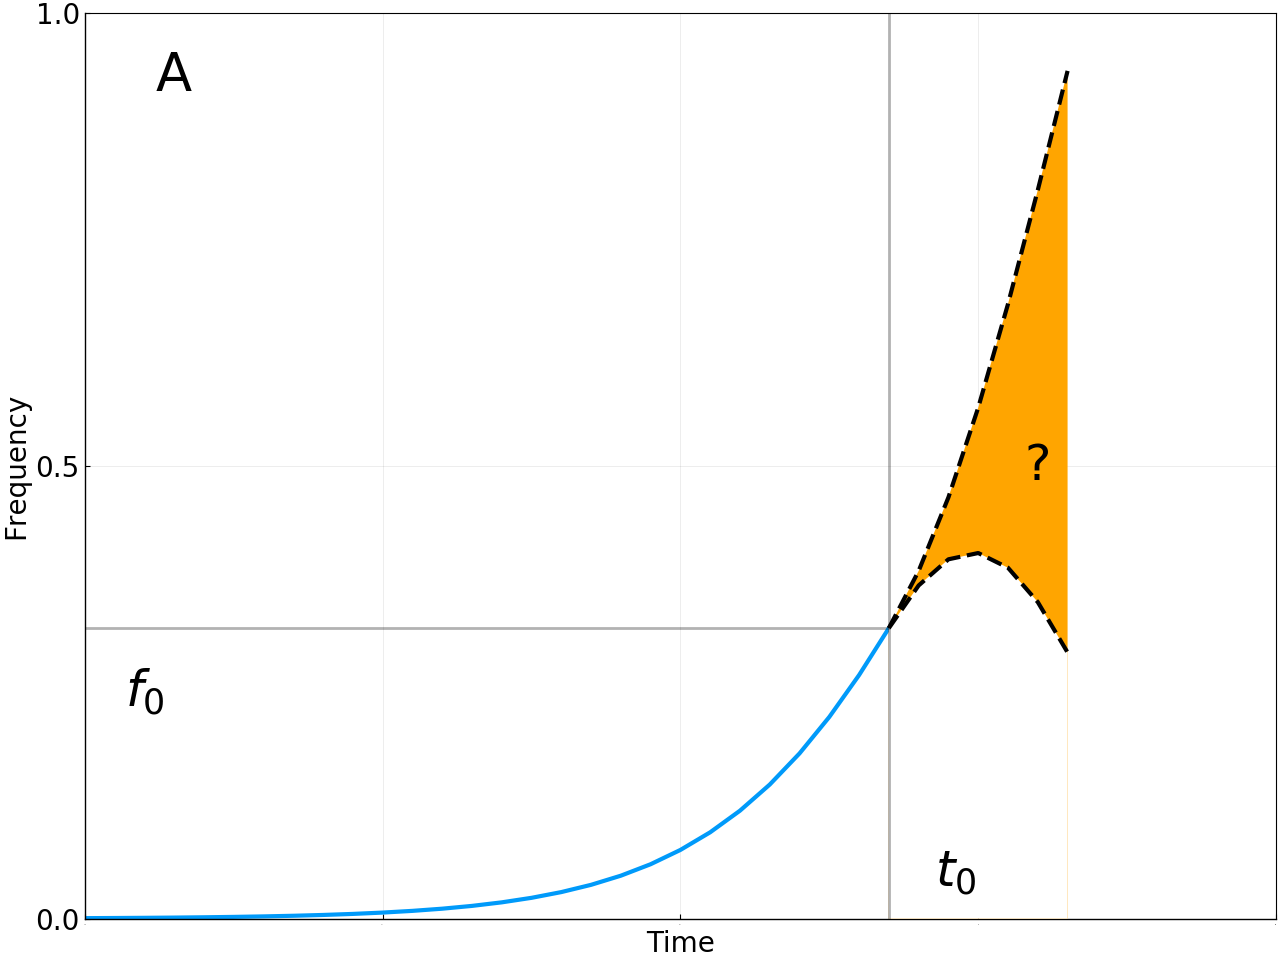

In [23]:
f(x,xe) = exp(x/xe) / (1+exp(x/xe)) 
g(x) = x^2/2
X = -30:-3
Y = f.(X,4)
x2 = -3:3
#
p = plot()
plot!(X,Y,ylim=(0,1),xlim=(-30,10), size=(640,640), label="", linewidth=3)
plot!(p, x2, 2*(f.(x2,4) .- Y[end]).^2 + f.(x2,4), line=(3,:dash, :black), label="",fill=(0,:orange))
plot!(p, x2, -3*(f.(x2,4) .- Y[end]).^2 + f.(x2,4), line=(3,:dash, :black), label="", fill=(0,:white))
plot!(p,[-3,-3], [0,1], line=(2, :black),label="", alpha=0.3)
plot!(p, [-30, -3], [f(-3,4), f(-3,4)], label="", line=(2,:black,0.3))
plot!(guidefontsize=alfs, tickfontsize=tfs)
plot!(yticks = [0., 0.5, 1.])
plot!(ann = (2., 0.5, text("?",36)))
plot!(ann = [(-28, 0.25, text(L"f_0",36)), (-0.75, 0.05, text(L"t_0",36))] )
plot!(ann = (-27, 0.93, text("A",annfs)))
plot!(p, xtickfontsize=0, xlabel="Time",ylabel="Frequency", frame=:box)
p2_sb1 = p;
plot!(p, size=(1280,960))


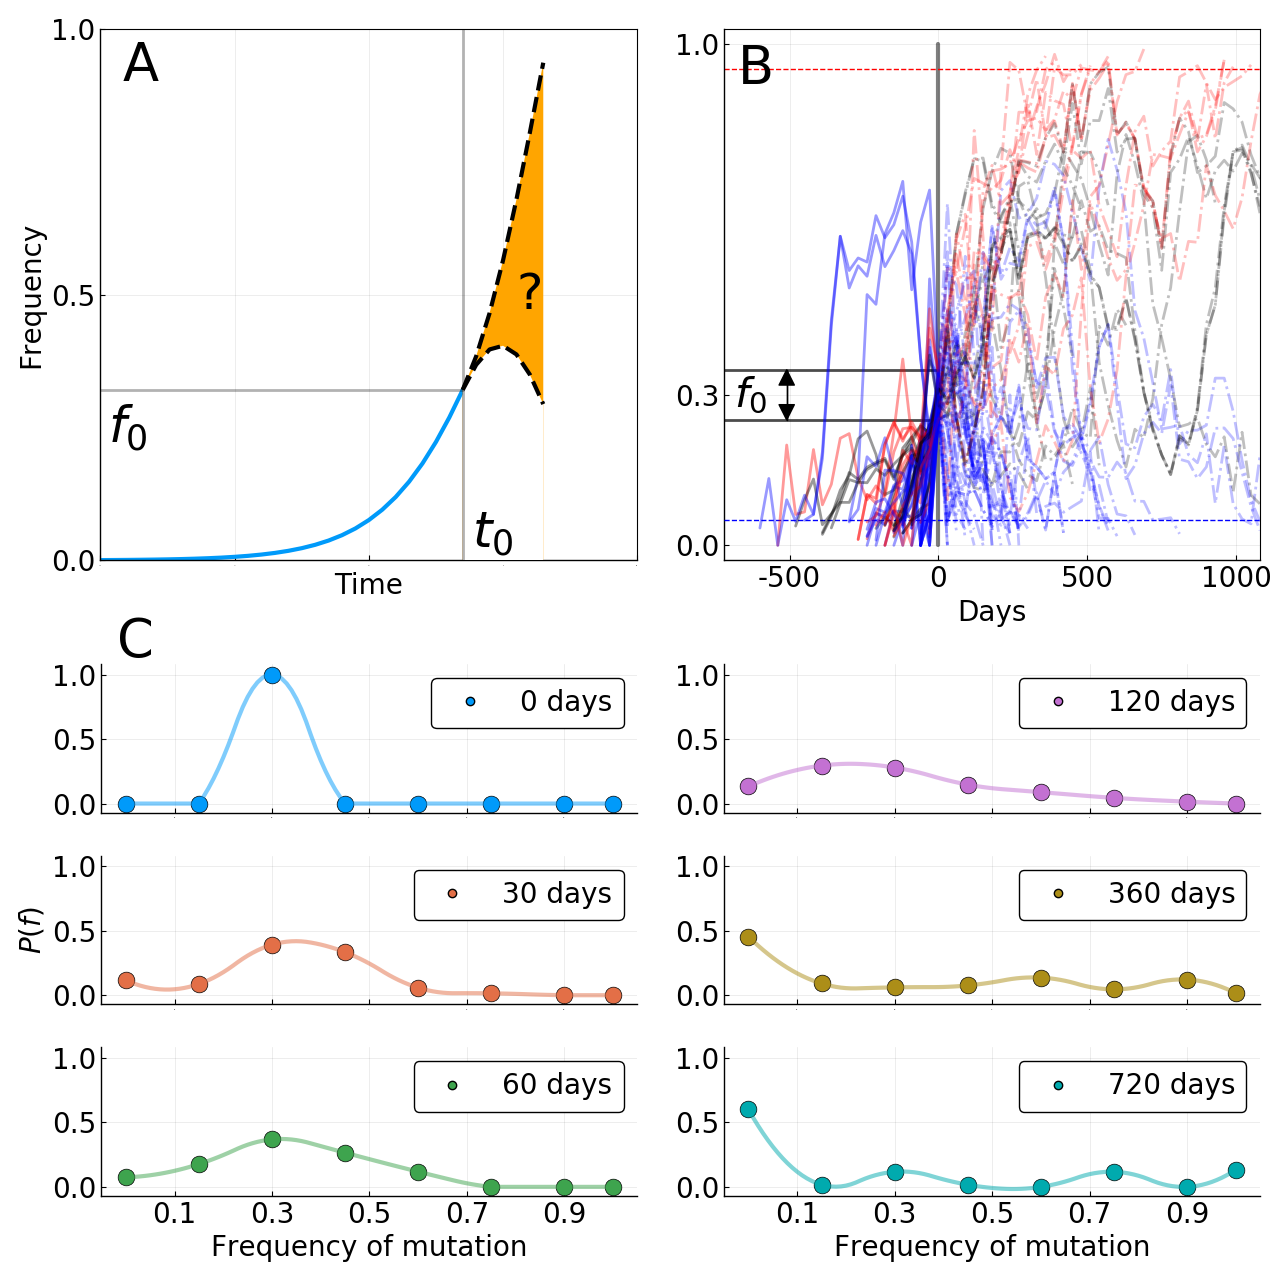

In [24]:
tmp = plot(p2_sb1, p2_sb2, layout=grid(1,2), size=(1280,640), right_margin=5.1mm)
p2 = plot(tmp, p2_sb3, layout = grid(2,1), size=(1280,1280), margin = 5mm)

In [30]:
x = Int64[]
y = Float64[]
tidx = [-4,-2,0, 1, 2, 4, 6, 12, 24]
for traj in trajectories
    is = traj.index[:active]
    ie = is+3
    idx = is .+ tidx
    for (ii,i) in enumerate(idx)
        if i > length(traj.t)
            t = (i-is)*binspacing.value
            traj.fixation != :poly && push!(y, traj.fixation==:fixed ? 1. : 0.)
            traj.fixation != :poly && push!(x, ii)
        elseif i > 0
            push!(y, traj.freq[i])
            push!(x, ii)
        end
    end
end

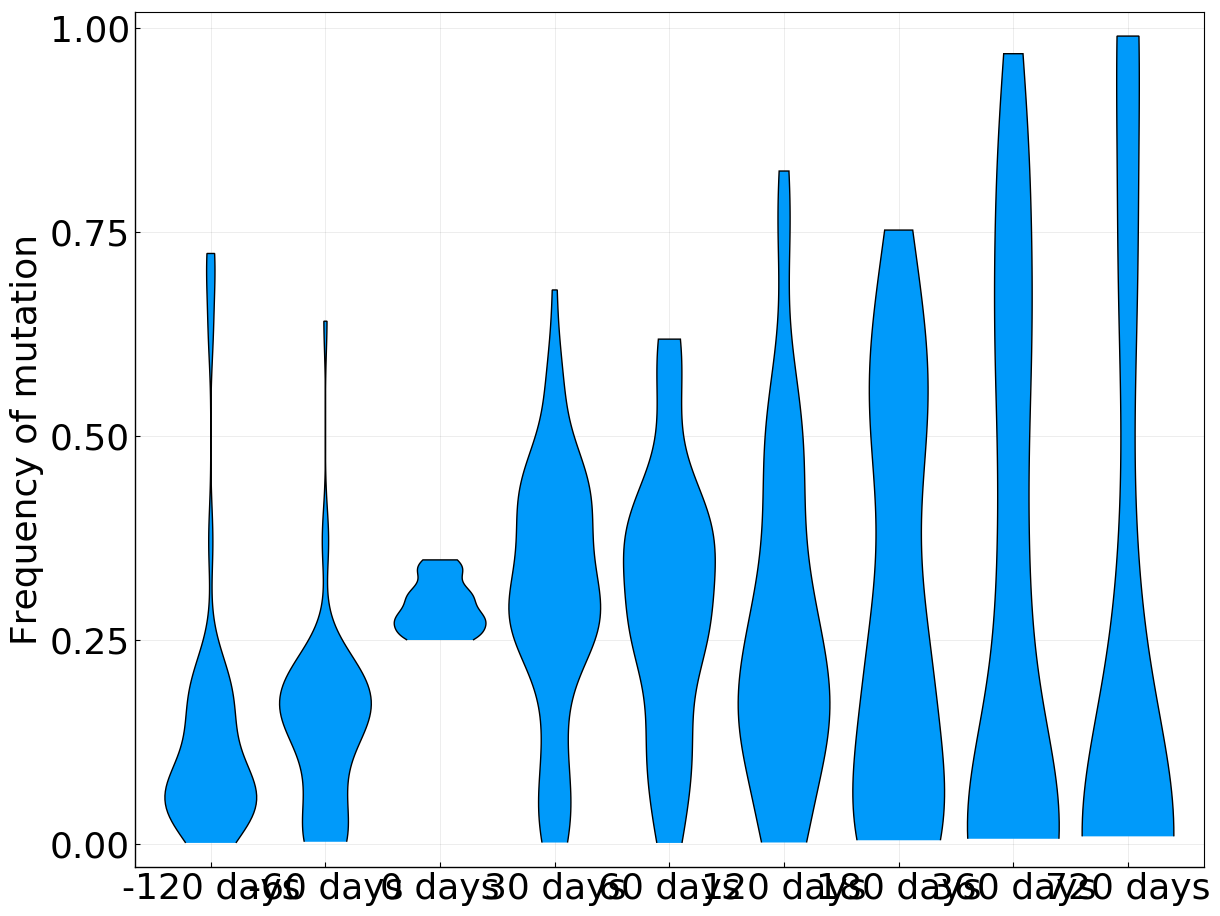

In [35]:
p = violin(x,y, label="")
plot!(p, xticks = (collect(1:length(tidx)), ["$(i*binspacing.value) days" for i in tidx]) )
# plot!(title="Days after observation")
plot!(ylabel="Frequency of mutation")
plot!(size=(1200,900), frame=:box, tickfontsize=atfs, guidefontsize=alfs)
savefig("$(plotfolder)/Distribution_v_time_violins.png")